In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import Galactic, ICRS
from astropy import units as u
from modules.velocity_transformations import equatorial_UVW
from modules.vr_opt import VrOpt
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import normalized_mutual_info_score
import hdbscan
from sklearn.neighbors import kneighbors_graph, sort_graph_by_row_values

# Idea

TODO:
1. Create graph over data (e.g. kNN graph)
2. Compute pairwise velocity differences for all pairs connected by an edge (already supported by VrOpt)
3. Cut graph using velocity differences (maximal velocity difference)
4. Remaining connected components are "complete linkage" clusters
5. Take remaining connected components and cluster them in XYZ space using SigMA


In [355]:
# Plotting related stuff
alphas = [0.9, 0.9, 0.3]
colors = ['tab:red', 'tab:blue', 'tab:grey']
zorders = [1, 1, 0]
log = True

In [356]:
# Create 6D Gaussian data
n = 1000
X_bg = (np.random.rand(n*5, 6) - 0.5) * 50

mu = np.array([-5, 5, 5, 5, -5, 5])
c_xx = c_yy = 20
c_xy = 15
c_zz = 3
c_uvw = 1
cov = np.diag([c_xx, c_yy, c_zz, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy
# Add signal
X_sig_1 = np.random.multivariate_normal(mu, cov, n//2)

# Second cluster
mu_2 = np.array([5, -5, -5, -5, 5, -5])
c_xx_2 = c_yy = 20
c_xy_2 = -15
c_zz_2 = 3
cov = np.diag([c_xx_2, c_yy, c_zz_2, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy_2
X_sig_2 = np.random.multivariate_normal(mu_2, cov, n//2)

X = np.concatenate([X_bg, X_sig_1, X_sig_2], axis=0)
labels = np.concatenate([np.zeros(n*5), np.ones(n//2), np.ones(n//2)*2])

df = pd.DataFrame(X, columns=['x', 'y', 'z', 'vx', 'vy', 'vz'])
# Transform to spherical coordinates
gal_coords = Galactic(
    u=df.x.values * u.pc,
    v=df.y.values * u.pc,
    w=df.z.values * u.pc,
    # velocities UVW
    U=df.vx.values * u.km / u.s,
    V=df.vy.values * u.km / u.s,
    W=df.vz.values * u.km / u.s,
    representation_type="cartesian",
    # Velocity representation
    differential_type="cartesian",
)
# transform to ICRS
icrs_coords = gal_coords.transform_to(ICRS())
icrs_coords.representation_type = "spherical"

ra = icrs_coords.ra.value
dec = icrs_coords.dec.value
dist = icrs_coords.distance.value
pmra = icrs_coords.pm_ra.value * np.cos(np.deg2rad(dec))
pmdec = icrs_coords.pm_dec.value
rv_calc = icrs_coords.radial_velocity.value

df['ra'] = ra
df['dec'] = dec
df['dist'] = dist
df['pmra'] = pmra
df['pmdec'] = pmdec
df['radial_velocity'] = rv_calc

df['vt_ra'] = df.pmra * df.dist * 4.74
df['vt_dec'] = df.pmdec * df.dist * 4.74

idx_cluster_1 = np.where(labels==1)[0]
idx_cluster_2 = np.where(labels==2)[0]
idx_bg = np.where(labels==0)[0]

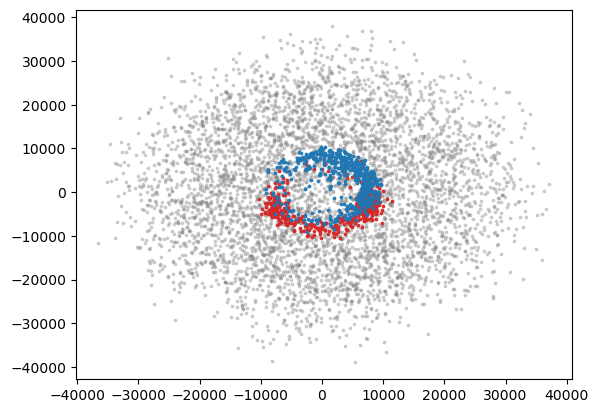

In [360]:
# x_col, y_col = 'x', 'y'
# x_col, y_col = 'vx', 'vy'
x_col, y_col = 'vt_ra', 'vt_dec'
# x_col, y_col = 'pmra', 'pmdec'
for idx_sel, alpha, c, zo in zip([idx_cluster_1, idx_cluster_2, idx_bg], alphas, colors, zorders): 
    plt.scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, c=c, alpha=alpha, zorder=zo)

In [338]:
U, V, W = equatorial_UVW(
    ra,
    dec,
    pmra,
    pmdec,
    rv_calc,
    dist,
)
# Check if the transformation is correct
np.allclose(U, df.vx.values, atol=1e-1), np.allclose(V, df.vy.values, atol=1e-1), np.allclose(W, df.vz.values, atol=1e-1)

(True, True, True)

# Compute optimal radial velocity of pairs

In [339]:
# The code below is just a test to check if the optimal radial velocity is computed correctly

# est = VrOpt(ra, dec, pmra, pmdec, dist)
# 
# for i, j in zip(range(10), range(10, 20)):
#     rv_i, rv_j, d_v = est.vr_opt(i, j)
#     idx = np.array([i, j])
#     U, V, W = equatorial_UVW(
#         ra[idx],
#         dec[idx],
#         pmra[idx],
#         pmdec[idx],
#         np.array([rv_i, rv_j]),
#         dist[idx],
#     )
#     norm_est = np.linalg.norm([U[0] - U[1], V[0] - V[1], W[0] - W[1]])
#     norm_real = np.linalg.norm([df.vx[i] - df.vx[j], df.vy[i] - df.vy[j], df.vz[i] - df.vz[j]])
# 
#     print(f"Real: {norm_real}, Est: {norm_est}, Comp est: {d_v}")

# Optimal radial velocity class
VrOpt computes pairwise minimal 3D velocity difference (in Cartesian space) for a given set of stars.

In [340]:
est = VrOpt(ra, dec, pmra, pmdec, dist)

In [457]:
# Create pairwise combinations of cluster indices
i, j = np.meshgrid(idx_cluster_2, idx_cluster_2)
i, j = i.flatten(), j.flatten()
# Remove values where i == j
mask = i != j
i, j = i[mask], j[mask]

_, _, delta_v_sig = est.vr_opt(i, j)

In [458]:
# Create pairwise combinations of background and signal indices
# n, m = np.meshgrid(idx_cluster_1, idx_cluster_2)
n, m = np.meshgrid(idx_cluster_1, idx_bg)
n, m = n.flatten(), m.flatten()

_, _, delta_v_bg = est.vr_opt(n, m)

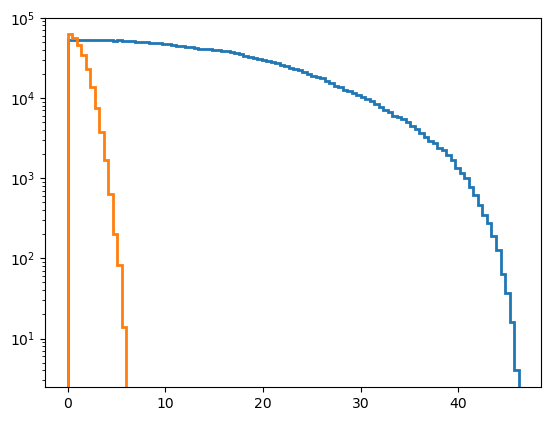

In [459]:
_, bins, _ = plt.hist(delta_v_bg, bins=100, log=log, histtype='step', lw=2)
plt.hist(delta_v_sig, bins=bins, log=log, histtype='step', lw=2);

# Comparison to tangential velocity differences

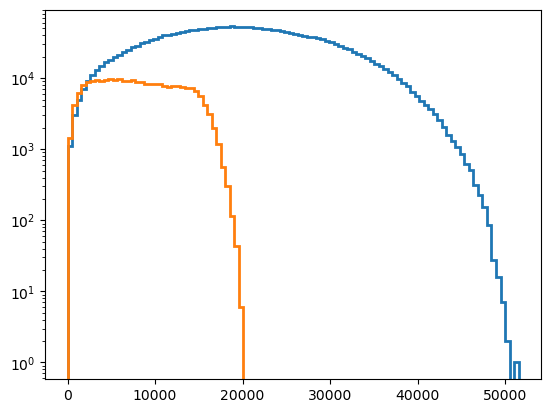

In [460]:
# Compute pair wise differences
X_vt = df[['vt_ra', 'vt_dec']].values
dist_vt = pairwise_distances(X_vt)

_, bins, _ = plt.hist(dist_vt[n, m], bins=100, log=True, histtype='step', lw=2)
plt.hist(dist_vt[i, j], bins=bins, log=True, histtype='step', lw=2);

# First cluster with HDBSCAN

0.6619741133992209


/var/folders/q4/vrqcgjz9259cd9jkzmpv3zth0000gn/T/ipykernel_76036/130435108.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fit[['vt_ra', 'vt_dec']] /= 300


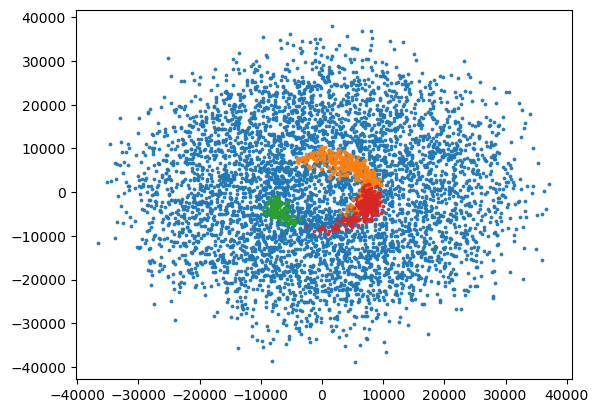

In [465]:
# Cluster data naively using HDBSCAN
clusterer_classic = hdbscan.HDBSCAN(min_cluster_size=30, metric='l2')
df_fit = df[['x', 'y', 'z', 'vt_ra', 'vt_dec']]
df_fit[['vt_ra', 'vt_dec']] /= 300 
clusterer_classic.fit(df_fit)

labels_classic = clusterer_classic.labels_
# labels_classic[labels_classic == 1] = 0
print(normalized_mutual_info_score(labels, labels_classic))

x_col = 'vt_ra'
y_col = 'vt_dec'
for l_i in np.unique(labels_classic):
    idx_sel = labels_classic == l_i
    plt.scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, alpha=alpha)

# Now built the distance matrix for clustering ourselves

In [467]:
# # Lower triangular matrix indices
a, b = np.tril_indices(len(X), -1)
_, _, delta_v = est.vr_opt(a, b)

# Create pairwise distance matrix with delta_v entries
dist_v_opt = np.zeros((len(X), len(X)))
dist_v_opt[a, b] = delta_v
dist_v_opt[b, a] = delta_v

In [462]:
# Also bring distance into it
dist_xyz = pairwise_distances(df[['x', 'y', 'z']].values)

In [463]:
# Mix the two distance matrices
alpha = 0.9
dist_tot = alpha * dist_v_opt + (1 - alpha) * dist_xyz

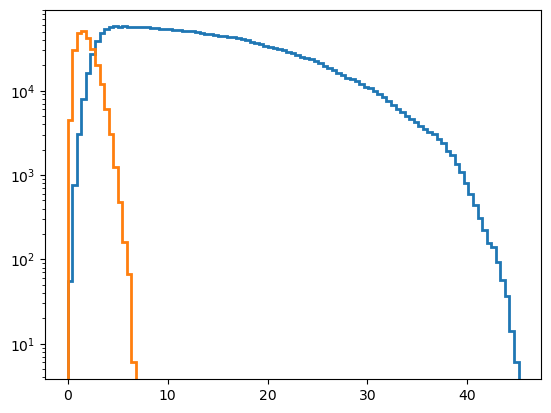

In [464]:
# Plot the combined distance matrix
# max_val = np.max([np.max(dist_tot[i, j]), np.max(dist_tot[n, m])])
# _, bins, _ = plt.hist(dist_tot[n, m], bins=np.linspace(0, max_val, 100), log=True, histtype='step', lw=2)
# plt.hist(dist_tot[i, j], bins=bins, log=True, histtype='step', lw=2);

In [468]:
# Cluster points using the combined distance matrix
clusterer = AgglomerativeClustering(linkage='complete', metric='precomputed', distance_threshold=10, n_clusters=None)
clusterer.fit(dist_tot)

AgglomerativeClustering(distance_threshold=10, linkage='complete',
                        metric='precomputed', n_clusters=None)

In [470]:
cl_id, cl_count = np.unique(clusterer.labels_, return_counts=True)

# Keep only the largest cluster
min_cluster_size = 50  # Minimum number of points in a cluster
labels_new = -np.ones_like(clusterer.labels_)

for cl_i in cl_id:
    if np.sum(clusterer.labels_==cl_i) > min_cluster_size:
        print(cl_i, cl_i)
        labels_new[clusterer.labels_ == cl_i] = cl_i 

# labels_new[clusterer.labels_ == cl_id[np.argmax(cl_count)]] = 1
np.unique(labels_new, return_counts=True)
normalized_mutual_info_score(labels, labels_new)

254 254
586 586


0.8379093881596189

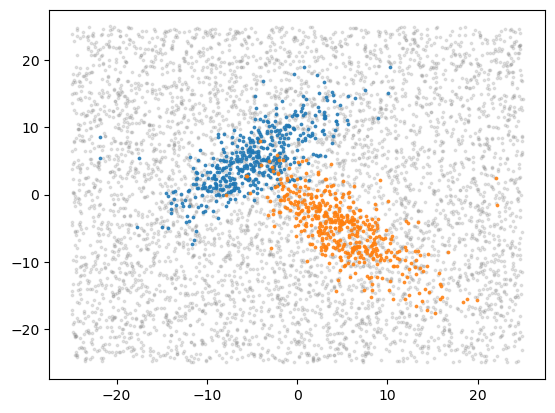

In [473]:
# x_col, y_col = 'vt_ra', 'vt_dec'
x_col, y_col = 'x', 'y'
# x_col, y_col = 'pmra', 'pmdec'
for l_i in np.unique(labels_new):
    if l_i != -1:
        idx_sel = labels_new == l_i
        plt.scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, alpha=0.8, zorder=1)
        
plt.scatter(df.loc[labels_new==-1, x_col], df.loc[labels_new==-1, y_col], s=3, alpha=0.2, c='tab:grey', zorder=0)

In [478]:
nmi_hdbscan = normalized_mutual_info_score(labels, labels_classic)
nmi_own = normalized_mutual_info_score(labels, labels_new)

print(f"NMI HDBSCAN: {nmi_hdbscan:.2f}, NMI Own: {nmi_own:.2f}")

NMI HDBSCAN: 0.66, NMI Own: 0.84
